# Example Notebook for use of CosMomentum
## Table of contents:

- Section 1: initialising a universe and its matter content
- Section 2: computing the PDF of matter density fluctuations
- Section 3: computing the cumulant generating function and individual connected moments
- Section 4: creating 3D galaxy samples and computing their counts-in-cells PDF
- Section 5: creating line-of-sight projected galaxy samples and computing their counts-in-cells PDF
- Section 6: convergence PDFs

In [1]:
# loading required packages
import ctypes
import sys
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
# compiling and loading c++ library
os.system("cd cpp_code; make DSS")
lib=ctypes.CDLL("./cpp_code/DSS.so")

# Section 1: initialising a universe and its matter content

In [3]:
# initialising a new universe and its matter content
a_initial = 0.000025
a_final = 1.0

initialise_new_Universe = lib.initialise_new_Universe
# initialise_new_Universe          (double a_initial,  double a_final,  double Omega_m,  double Omega_b,  double Omega_r,  double Omega_L,  double sigma_8,      double n_s,    double h_100,       double w0,       double w1)
initialise_new_Universe.argtypes = [ ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double]
initialise_new_Universe.restype = None


# Cosmology of DEUS sims
Omfid = 0.2573
Obfid = 0.04356 
hfid = 0.7200
nsfid = 0.9630
sig8fid = 0.8010

# Cosmology of Buzzard sims
Omfid = 0.286
Obfid = 0.047
hfid = 0.7
nsfid = 0.96
sig8fid = 0.82

# Cosmology of Quijote sims
Omfid = 0.3175
Obfid = 0.049
hfid = 0.6711
nsfid = 0.9624
sig8fid = 0.834

# Cosmology of PotC lecture
Omfid = 0.3
Obfid = 0.049
hfid = 0.7
nsfid = 0.9624
sig8fid = 0.834

# DES year 1 DSS best fit cosmology
Omfid = 0.283
Obfid = 0.047
hfid = 0.7
nsfid = 0.96
sig8fid = 0.801

# Cosmology of Quijote sims
Omfid = 0.3175
Obfid = 0.049
hfid = 0.6711
nsfid = 0.9624
sig8fid = 0.834

z = 1.0 # everywhere in this notebook

initialise_new_Universe(a_initial, a_final, Omfid, Obfid, 0.0, 1.0-Omfid, sig8fid, nsfid, hfid, -1.0, 0.0)


In [4]:
return_variance_L_3D = lib.return_variance_L_3D
# return_variance_L_3D          (       double z, double R_in_comoving_Mpc, int index_of_universe)
return_variance_L_3D.argtypes = [ctypes.c_double,          ctypes.c_double,          ctypes.c_int]
return_variance_L_3D.restype = ctypes.c_double

return_variance_NL_3D = lib.return_variance_NL_3D
# return_variance_NL_3D          (       double z, double R_in_comoving_Mpc, double var_NL_rescale, int index_of_universe)
return_variance_NL_3D.argtypes = [ctypes.c_double,          ctypes.c_double,       ctypes.c_double,          ctypes.c_int]
return_variance_NL_3D.restype = ctypes.c_double

return_skewness_NL_3D = lib.return_skewness_NL_3D
# return_skewness_NL_3D          (       double z, double R_in_comoving_Mpc,     double f_NL, double var_NL_rescale, int index_of_universe)
return_skewness_NL_3D.argtypes = [ctypes.c_double,          ctypes.c_double, ctypes.c_double,       ctypes.c_double,          ctypes.c_int]
return_skewness_NL_3D.restype = ctypes.c_double

### Computing the skewness of the linear density field
### Defining $\epsilon_3(R) \equiv <\delta_R^3>/\sigma_R^2$ the function set_primordial_skewness_from_eps3_powerlaw_approximation assumed that $\epsilon_3(R) \approx A_{\epsilon_3}*(R/R_0)^{n_{\epsilon_3}}$ and computes $A_{\epsilon_3}$ and $n_{\epsilon_3}$ at $R = R_0$.
### Alternatively, see also set_primordial_skewness and set_primordial_skewness_from_file in python_interfaces.cpp

In [5]:

set_primordial_skewness_from_eps3_powerlaw_approximation = lib.set_primordial_skewness_from_eps3_powerlaw_approximation
# set_primordial_skewness_from_eps3_powerlaw_approximation          (int index_of_universe, int PNG_modus, double R_0_in_Mpc_over_h)
set_primordial_skewness_from_eps3_powerlaw_approximation.argtypes = [           ctypes.c_int,  ctypes.c_int,          ctypes.c_double]
set_primordial_skewness_from_eps3_powerlaw_approximation.restype = None

set_primordial_skewness_from_eps3_powerlaw_approximation(0, 1, 15.0)

# Section 2: computing the PDF of matter density fluctuations

In [6]:

# N_delta has to be hardcoded, because is it needed for defining the python-c++ interface
return_Ndelta = lib.return_Ndelta
return_Ndelta.argtypes = []
return_Ndelta.restype = ctypes.c_int
N_delta = return_Ndelta()

return_PDF = lib.return_PDF
# return_PDF          (                   double* delta_values,                                      double* PDF,        double z, double R_in_comoving_Mpc,     double f_NL, double var_NL_rescale, int index_of_universe)
return_PDF.argtypes = [ctypes.POINTER(ctypes.c_double*N_delta),          ctypes.POINTER(ctypes.c_double*N_delta), ctypes.c_double,          ctypes.c_double, ctypes.c_double,       ctypes.c_double,          ctypes.c_int]
return_PDF.restype = None

## This function returns the probability distribution function (PDF) of the 3D matter density field
# - at redshift z
# - top-hat smoothing radius R [Mpc/h]
# - with primordial bispectrum amplitute f_NL
# - non-linear variance being var_NL_rescale*halofit (Takahashi et al. 2012, Smith et al. 2003)
# - for universe index_of_universe (= 0 if you have only created one universe
def PDF_from_inv_Laplace_transform(z, R, f_NL, var_NL_rescale, index_of_universe):
    delta_values     = (ctypes.c_double*N_delta)()
    PDF_values       = (ctypes.c_double*N_delta)()
    return_PDF(ctypes.byref(delta_values), ctypes.byref(PDF_values), z, R, f_NL, var_NL_rescale, index_of_universe)
    return np.array(delta_values), np.array(PDF_values)



return_Nlambda = lib.return_Nlambda
return_Nlambda.argtypes = [ctypes.c_int]
return_Nlambda.restype = ctypes.c_int
N_lambda = return_Nlambda(0)

return_CGF = lib.return_CGF
#           return_CGF(                         double* delta_L,                           double* lambda,                              double* phi,              double* dphi_dlambda_values,            double* d2phi_dlambda2_values,            double* d3phi_dlambda3_values,    int* N_lambda_uncollapsed,        double z, double R_in_comoving_Mpc,     double f_NL, double var_NL_rescale, int index_of_universe)
return_CGF.argtypes = [ctypes.POINTER(ctypes.c_double*N_lambda), ctypes.POINTER(ctypes.c_double*N_lambda), ctypes.POINTER(ctypes.c_double*N_lambda), ctypes.POINTER(ctypes.c_double*N_lambda), ctypes.POINTER(ctypes.c_double*N_lambda), ctypes.POINTER(ctypes.c_double*N_lambda), ctypes.POINTER(ctypes.c_int), ctypes.c_double,          ctypes.c_double, ctypes.c_double,       ctypes.c_double,          ctypes.c_int]
return_CGF.restype = None

## This function returns the cumulant generating function (CGF) of the 3D matter density field
# - at redshift z
# - top-hat smoothing radius R [Mpc/h]
# - with primordial bispectrum amplitute f_NL
# - non-linear variance being var_NL_rescale*halofit (Takahashi et al. 2012, Smith et al. 2003)
# - for universe index_of_universe (= 0 if you have only created one universe)
def CGF(z, R, f_NL, var_NL_rescale, index_of_universe):
    delta_L_values        = (ctypes.c_double*N_lambda)()
    lambda_values         = (ctypes.c_double*N_lambda)()
    phi_values            = (ctypes.c_double*N_lambda)()
    dphi_dlambda_values   = (ctypes.c_double*N_lambda)() # == delta_NL_values
    d2phi_dlambda2_values = (ctypes.c_double*N_lambda)()
    d3phi_dlambda3_values = (ctypes.c_double*N_lambda)()
    N_lambda_uncollapsed  = (ctypes.c_int)()
    #
    return_CGF(ctypes.byref(delta_L_values), ctypes.byref(lambda_values), ctypes.byref(phi_values), ctypes.byref(dphi_dlambda_values), ctypes.byref(d2phi_dlambda2_values), ctypes.byref(d3phi_dlambda3_values), ctypes.byref(N_lambda_uncollapsed), z, R, f_NL, var_NL_rescale, index_of_universe)
    N_lambda_uncollapsed = N_lambda_uncollapsed.value
    return np.array(delta_L_values)[:N_lambda_uncollapsed], np.array(lambda_values)[:N_lambda_uncollapsed], np.array(phi_values)[:N_lambda_uncollapsed], np.array(dphi_dlambda_values)[:N_lambda_uncollapsed], np.array(d2phi_dlambda2_values)[:N_lambda_uncollapsed], np.array(d3phi_dlambda3_values)[:N_lambda_uncollapsed]

## This function returns the PDF of the 3D matter density field using a saddle point
## approximation to solve the inverse Laplace transform that relates PDF and CGF.
# - at redshift z
# - top-hat smoothing radius R [Mpc/h]
# - with primordial bispectrum amplitute f_NL
# - non-linear variance being var_NL_rescale*halofit (Takahashi et al. 2012, Smith et al. 2003)
# - for universe index_of_universe (= 0 if you have only created one universe
def PDF_from_saddlepoint(z, R, delta_min, delta_max, f_NL, var_NL_rescale, index_of_universe):
    d_L, l, phi, dphi_dl, d2phi_dl2, d3phi_dl3 = CGF(z, R, f_NL, var_NL_rescale, index_of_universe)
    Nl = len(l)
    ddelta = (delta_max-delta_min)/float(N_delta-1)
    delta_values     = np.arange(0, N_delta)*ddelta+delta_min
    PDF_values       = np.zeros(N_delta)
    phi_interp = np.interp(delta_values, dphi_dl, phi)
    phi_prime_prime_interp = np.interp(delta_values, dphi_dl, d2phi_dl2)
    l_interp = np.interp(delta_values, dphi_dl, l)
    indeces = np.where(phi_prime_prime_interp>0.0)[0]
    PDF_values[indeces]       = np.exp(-l_interp[indeces]*delta_values[indeces]+phi_interp[indeces])/np.sqrt(2.0*np.pi*phi_prime_prime_interp[indeces])
    return delta_values, PDF_values


## This function returns the PDF of the 3D matter density field using a saddle point
## approximation to solve the inverse Laplace transform that relates PDF and CGF.
# - at redshift z
# - top-hat smoothing radius R [Mpc/h]
# - with primordial bispectrum amplitute f_NL
# - non-linear variance being var_NL_rescale*halofit (Takahashi et al. 2012, Smith et al. 2003)
# - for universe index_of_universe (= 0 if you have only created one universe
def PDF_asymptote(z, R, delta_min, delta_max, f_NL, var_NL_rescale, index_of_universe):
    d_L, l, phi, dphi_dl, d2phi_dl2, d3phi_dl3 = CGF(z, R, f_NL, var_NL_rescale, index_of_universe)
    Nl = len(l)
    ddelta = (delta_max-delta_min)/float(N_delta-1)
    delta_values     = np.arange(0, N_delta)*ddelta+delta_min
    PDF_values       = np.zeros(N_delta)
    phi_interp = np.interp(delta_values, dphi_dl, phi)
    phi_prime_prime_interp = np.interp(delta_values, dphi_dl, d2phi_dl2)
    phi_prime_prime_prime_interp = np.interp(delta_values, dphi_dl, d3phi_dl3)
    #
    #plt.plot(l_center, d3phi_dl3, linewidth=3, linestyle='solid', label='inverse Laplace')
    plt.figure(figsize=(7, 15))
    indx = np.argmax(d2phi_dl2)
    x1 = l[indx]
    x2 = l[indx+1]
    f1 = 1/d2phi_dl2[indx]
    f2 = 1/d2phi_dl2[indx+1]
    l_crit = (x1/f1-x2/f2)/(1.0/f1-1.0/f2)
    phi_crit = np.max(phi)
    phi_prime_crit = dphi_dl[indx]
    print(l[indx], 1/d2phi_dl2[indx])
    print(l[indx+1], 1/d2phi_dl2[indx+1])
    print(l_crit)
    indxs = np.where(l[:-1] <= l[1:])[0]
    x = np.sqrt(l_crit - l[indxs])
    x_test = np.sqrt(l[indx] - l[indxs])
    #plt.plot(l, dphi_dl, linewidth=3, linestyle='solid', label='inverse Laplace')
    plt.plot(dphi_dl, d2phi_dl2, linewidth=3, linestyle='solid', label='inverse Laplace')
    plt.plot(dphi_dl[indxs], 12*d2phi_dl2[indxs]*x, linewidth=3, linestyle='solid', label='inverse Laplace')
    plt.plot(dphi_dl[indxs], 8*d3phi_dl3[indxs]*x**3, linewidth=3, linestyle='solid', label='inverse Laplace')
    fppp = 4.0*x*(3.0*d2phi_dl2[indxs] - 2.0*d3phi_dl3[indxs]*x**2)
    plt.xlim(0, 4)
    plt.ylim(-1, 30)
    fppp0 = np.max(fppp)
    print(fppp0)
    #
    d = np.linspace(phi_prime_crit, 10*delta_max, 1000)
    p = 3.0/(4.0*np.sqrt(np.pi))*fppp0/6.0*np.exp(phi_crit-l_crit*d)/(d-phi_prime_crit)**(5.0/2.0)
    return d, p


def PDF_asymptote2(z, R, delta_min, delta_max, f_NL, var_NL_rescale, index_of_universe):
    d_L, l, phi, dphi_dl, d2phi_dl2, d3phi_dl3 = CGF(z, R, f_NL, var_NL_rescale, index_of_universe)
    Nl = len(l)
    ddelta = (delta_max-delta_min)/float(N_delta-1)
    delta_values     = np.arange(0, N_delta)*ddelta+delta_min
    PDF_values       = np.zeros(N_delta)
    phi_interp = np.interp(delta_values, dphi_dl, phi)
    phi_prime_prime_interp = np.interp(delta_values, dphi_dl, d2phi_dl2)
    phi_prime_prime_prime_interp = np.interp(delta_values, dphi_dl, d3phi_dl3)
    #
    #plt.plot(l_center, d3phi_dl3, linewidth=3, linestyle='solid', label='inverse Laplace')
    plt.figure(figsize=(7, 15))
    indx = np.argmax(d2phi_dl2)
    x1 = l[indx]
    x2 = l[indx+1]
    f1 = 1/d2phi_dl2[indx]
    f2 = 1/d2phi_dl2[indx+1]
    l_crit = (x1/f1-x2/f2)/(1.0/f1-1.0/f2)
    phi_crit = np.max(phi)
    phi_prime_crit = dphi_dl[indx]
    print(l[indx], 1/d2phi_dl2[indx])
    print(l[indx+1], 1/d2phi_dl2[indx+1])
    print(l_crit)
    indxs = np.where(l[:-1] <= l[1:])[0]
    x = np.sqrt(l_crit - l[indxs])
    x_test = np.sqrt(l[indx] - l[indxs])
    #plt.plot(l, dphi_dl, linewidth=3, linestyle='solid', label='inverse Laplace')
    plt.plot(dphi_dl, d2phi_dl2, linewidth=3, linestyle='solid', label='inverse Laplace')
    plt.plot(dphi_dl[indxs], 12*d2phi_dl2[indxs]*x, linewidth=3, linestyle='solid', label='inverse Laplace')
    plt.plot(dphi_dl[indxs], 8*d3phi_dl3[indxs]*x**3, linewidth=3, linestyle='solid', label='inverse Laplace')
    fppp = 4.0*x*(3.0*d2phi_dl2[indxs] - 2.0*d3phi_dl3[indxs]*x**2)
    plt.xlim(0, 4)
    plt.ylim(-1, 30)
    fppp0 = np.max(fppp)
    print(fppp0)
    #
    d = np.linspace(phi_prime_crit, 10*delta_max, 1000)
    p = 3.0/(4.0*np.sqrt(np.pi))*fppp0/6.0*np.exp(phi_crit-l_crit*d)/(d)**(5.0/2.0)
    return d, p, l_crit, phi_prime_crit


In [7]:
# PDF from full inverse Laplace transform of the cumulant generating function
# assuming f_NL = 0.0
delta_values, PDF_values = PDF_from_inv_Laplace_transform(z, 15.0, 0.0, 1.0, 0)


In [8]:
# PDF from full inverse Laplace transform of the cumulant generating function
# assuming f_NL = 100.0
delta_values_PNG, PDF_values_PNG = PDF_from_inv_Laplace_transform(z, 15.0, 100.0, 1.0, 0)


In [9]:
# PDF from saddle point approximation of inverse Laplace transform
# assuming f_NL = 0.0
delta_values_saddle, PDF_values_saddle_point_approx = PDF_from_saddlepoint(z, 15.0, delta_values[0], delta_values[N_delta-1], 0.0, 1.0, 0)

In [10]:
print(np.max(PDF_values))
print(np.max(PDF_values_PNG))
print(np.max(PDF_values_saddle_point_approx))

1.4253027705662196
1.415005408047663
1.4196287578475646


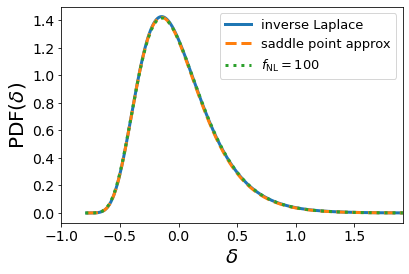

In [11]:
plt.plot(delta_values, PDF_values, linewidth=3, linestyle='solid', label='inverse Laplace')
plt.plot(delta_values_saddle, PDF_values_saddle_point_approx, linewidth=3, linestyle='dashed', label='saddle point approx')
plt.plot(delta_values_PNG, PDF_values_PNG, linewidth=3, linestyle='dotted', label=r'$f_{\mathrm{NL}} = 100$')


plt.legend(fontsize=13, loc='upper right')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
var = np.sum(delta_values**2*PDF_values)/np.sum(PDF_values)
plt.xlim(-1.0, 6.0*np.sqrt(var))

plt.xlabel(r'$\delta$', size = 20)
plt.ylabel(r'$\mathrm{PDF}(\delta)$', size = 20)
plt.subplots_adjust(left  = 0.18, right = 0.97, bottom=0.17, top=0.92)

# Section 3: computing the cumulant generating function and individual connected moments

## See sections 2.1 and 4.6 of https://arxiv.org/abs/1912.06621 for details

In [12]:

# This is code for extracting individual moments from the CGF (see section 4.6 of https://arxiv.org/abs/1912.06621):

def factoria(n):
    fact = np.ones(n+1)
    for i in range(1, n+1):
        fact[i] = fact[i-1]*float(i)
    return fact

def Bell_polynomial(n, k, x, fact):
    n = int(n+0.1)
    k = int(k+0.1)
    
    if n == 0 and k == 0:
        return 1.0
    if n == 0 and k != 0:
        return 0.0
    if n != 0 and k == 0:
        return 0.0
    
    sum = 0.0
    
    for i in range(1, n-k+2):
        binomial = fact[n-1]/fact[n-i]/fact[i-1]
        sum += x[i]*binomial*Bell_polynomial(n-i, k-1, x, fact)
    
    return sum


def return_Bell_matrix(lambda_coeffs_wrt_tau):
    n = len(lambda_coeffs_wrt_tau)
    fact = factoria(n)
    x = np.zeros(n);
    Bell_matrix = np.zeros((n,n))
    inverse_Bell_matrix = np.zeros((n,n))
    
    for i in range(0, n):
        x[i] = lambda_coeffs_wrt_tau[i]*fact[i];
        
    for i in range(0, n):
        for j in range(0, i+1):
            Bell_matrix[i,j] = Bell_polynomial(i, j, x, fact)
            
    inverse_Bell_matrix = np.linalg.inv(np.matrix(Bell_matrix))
    return inverse_Bell_matrix, Bell_matrix


def find_moments(lambda_values, phi_values, phi_prime_values, degree):
    n = len(lambda_values)
    indices = np.where(lambda_values[1:] > lambda_values[:n-1])[0]
    
    tau_values = np.sqrt(2.0*(lambda_values*phi_prime_values-phi_values))
    tau_values[np.where(lambda_values<0.0)[0]] *= -1
    
    lambda_max = lambda_values[0]
    check = 1
    n_cut = 0
    for i in range(1,n):
        if lambda_values[i] > lambda_max and check == 1:
            lambda_max = lambda_values[i]
            n_cut = i
        else:
            check = 0
    
    lambda_cut    = lambda_values[:n_cut]
    phi_cut       = phi_values[:n_cut]
    phi_prime_cut = phi_prime_values[:n_cut]
    tau_cut       = tau_values[:n_cut]
    
    tau_max = np.max(tau_cut)*0.9
    tau_min = np.min(tau_cut)*0.9
    
    N_tau = 8*degree+1
    N_tau_half_integer_division = int(N_tau/2)
    tau_support_points = np.zeros(N_tau)
    dtau = -tau_min/float(N_tau_half_integer_division)
    tau_support_points[:N_tau_half_integer_division] = np.arange(tau_min, 0.0-0.5*dtau, dtau)
    tau_support_points[N_tau_half_integer_division] = 0.0
    dtau = tau_max/float(N_tau_half_integer_division)
    tau_support_points[N_tau_half_integer_division+1:] = np.arange(0.0, tau_max-0.5*dtau, tau_max/float(N_tau_half_integer_division))+tau_max/float(N_tau_half_integer_division)
    phi_prime_points = np.interp(tau_support_points, tau_cut, phi_prime_cut)
    lambda_support_points = np.interp(tau_support_points, tau_cut, lambda_cut)
    
    delta_NL_coeffs_wrt_tau =  np.polyfit(tau_support_points, phi_prime_points, degree)
    delta_NL_coeffs_wrt_tau = np.flip(delta_NL_coeffs_wrt_tau)
    lambda_coeffs_wrt_tau =  np.polyfit(tau_support_points, lambda_support_points, degree)
    lambda_coeffs_wrt_tau = np.flip(lambda_coeffs_wrt_tau)
    
    inverse_Bell_matrix, Bell_matrix = return_Bell_matrix(lambda_coeffs_wrt_tau)
    
    delta_NL_coeffs_wrt_lambda = np.zeros(degree+1)
    fact = factoria(degree+1)
    
    for i in range(0, degree+1):
        for j in range(0, i+1):
            delta_NL_coeffs_wrt_lambda[i] += inverse_Bell_matrix[i,j]*delta_NL_coeffs_wrt_tau[j]*fact[j]
        #delta_NL_coeffs_wrt_lambda[i] /= fact[i]
    
    for i in range(degree, 0, -1):
        delta_NL_coeffs_wrt_lambda[i] = delta_NL_coeffs_wrt_lambda[i-1]#/float(i);
    delta_NL_coeffs_wrt_lambda[i] = 0.0
    
    return delta_NL_coeffs_wrt_lambda

In [13]:
var_NL_rescale = 1.0
f_NL = -3.0
R = 15.0

d_L_values, lambda_values, phi_values, phi_prime_values, phi_prime_prime_values, phi_prime_prime_prime_values = CGF(z, R, f_NL, var_NL_rescale, 0)
d_L_G_values, lambda_G_values, phi_G_values, phi_G_prime_values, phi_G_prime_prime_values, phi_G_prime_prime_prime_values = CGF(z, R, 0.0, var_NL_rescale, 0)

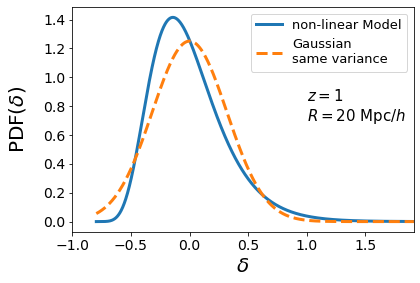

In [15]:
var = np.sum(delta_values_PNG**2*PDF_values_PNG)/np.sum(PDF_values_PNG)
plt.plot(delta_values_PNG, PDF_values_PNG, linewidth=3, linestyle='solid', label=r'non-linear Model')
plt.plot(delta_values_PNG, np.exp(-0.5*delta_values_PNG**2/var)/np.sqrt(2.0*np.pi*var), linewidth=3, linestyle='dashed', label='Gaussian\nsame variance')


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=13, loc='upper right')
var = np.sum(delta_values**2*PDF_values)/np.sum(PDF_values)
plt.xlim(-1.0, 6.0*np.sqrt(var))
plt.text(1.0,0.7,"$z=1$\n$R=20$ Mpc$/h$", size=15)

plt.xlabel(r'$\delta$', size = 20)
plt.ylabel(r'$\mathrm{PDF}(\delta)$', size = 20, labelpad=15)
plt.subplots_adjust(left  = 0.18, right = 0.97, bottom=0.19, top=0.97)
plt.savefig("plots/PDF_demonstration.pdf")

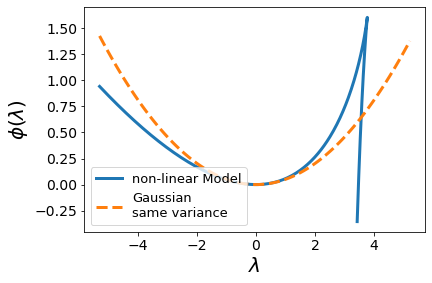

In [16]:
# Note the branch cut in the non-Gaussian CGF:
# CosMomentum only uses the 1st branch (branch extending to < 0)
# in order to compute the PDF.

dmin=-0.3
dmax = 9.0
i_min = np.argmin((phi_prime_values-dmin)**2)
i_max = np.argmin((phi_prime_values-dmax)**2)
plt.plot(lambda_values[i_min:i_max], phi_values[i_min:i_max], linewidth=3, label=r'non-linear Model')
ll = np.arange(lambda_values[i_min], -lambda_values[i_min], 0.1)
plt.plot(ll, 0.5*var*ll**2, linewidth=3, linestyle='dashed', label='Gaussian\nsame variance')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=13, loc='lower left')

plt.xlabel(r'$\lambda$', size = 20)
plt.ylabel(r'$\phi(\lambda)$', size = 20)
plt.subplots_adjust(left  = 0.18, right = 0.97, bottom=0.19, top=0.97)
plt.savefig("plots/CGF_demonstration.pdf")

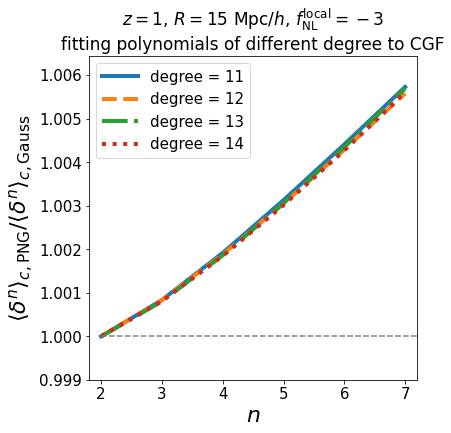

In [17]:
# Please don't use the function find_moments as a black box.
# Instead, please consider the remarks of caution at the end
# of section 4.6 of https://arxiv.org/pdf/1912.06621.pdf .
n_max = 8
plt.figure(figsize=(6,6))

moments_G = find_moments(lambda_G_values, phi_G_values, phi_G_prime_values, 11)
moments_PNG = find_moments(lambda_values, phi_values, phi_prime_values, 11)
plt.plot(range(2, n_max), moments_PNG[2:n_max]/moments_G[2:n_max], label='degree = 11', linewidth=4, linestyle='-')


moments_G = find_moments(lambda_G_values, phi_G_values, phi_G_prime_values, 12)
moments_PNG = find_moments(lambda_values, phi_values, phi_prime_values, 12)
plt.plot(range(2, n_max), moments_PNG[2:n_max]/moments_G[2:n_max], label='degree = 12', linewidth=4, linestyle='--')


moments_G = find_moments(lambda_G_values, phi_G_values, phi_G_prime_values, 13)
moments_PNG = find_moments(lambda_values, phi_values, phi_prime_values, 13)
plt.plot(range(2, n_max), moments_PNG[2:n_max]/moments_G[2:n_max], label='degree = 13', linewidth=4, linestyle='-.')


moments_G = find_moments(lambda_G_values, phi_G_values, phi_G_prime_values, 14)
moments_PNG = find_moments(lambda_values, phi_values, phi_prime_values, 14)
plt.plot(range(2, n_max), moments_PNG[2:n_max]/moments_G[2:n_max], label='degree = 14', linewidth=4, linestyle='dotted')


plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.plot(range(2, n_max+1), np.ones(n_max-1), linestyle='dashed', color='grey')
plt.xlim(1.8, n_max-0.8)
plt.ylim(0.999, 1.0 + 1.15*(moments_PNG[n_max-1]/moments_G[n_max-1]-1.0))
plt.legend(fontsize=15, handlelength=2.35)
plt.title('$z=1$, $R=15$ Mpc$/h$, '+r'$f_{\mathrm{NL}}^{\mathrm{local}} = -3$'+'\nfitting polynomials of different degree to CGF', size = 17)
plt.xlabel(r'$n$', size = 22)
plt.ylabel(r'$\langle \delta^n \rangle_{c,\mathrm{PNG}}/\langle \delta^n \rangle_{c,\mathrm{Gauss}}$', size = 22)
plt.subplots_adjust(left=0.19, bottom=0.12, right=0.95, top=0.87)

# Section 4: creating 3D galaxy samples and computing their counts-in-cells PDF

## This part uses the bias and shot-noise model described in section IV.C.2 of https://arxiv.org/abs/1710.05162 .

In [18]:

# bias_model = 0: Eulerian
# bias_model = 1: Lagrangian
add_3D_galaxy_sample = lib.add_3D_galaxy_sample
# add_3D_galaxy_sample          (int index_of_universe,        double z, double density_in_Mpc_over_h_cubed,        double b1,        double b2,       double a0,       double a1,   bias_model)
add_3D_galaxy_sample.argtypes = [         ctypes.c_int, ctypes.c_double,                    ctypes.c_double,  ctypes.c_double,  ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_int]
add_3D_galaxy_sample.restype = None

return_N_max_3D = lib.return_N_max_3D
# int return_N_max_3D      (int index_of_galaxy_sample, double R_in_Mpc_over_h, double var_NL_rescale)
return_N_max_3D.argtypes = [              ctypes.c_int,        ctypes.c_double,       ctypes.c_double]
return_N_max_3D.restype = ctypes.c_int

change_parameters_of_3D_galaxy_sample = lib.change_parameters_of_3D_galaxy_sample
# change_parameters_of_3D_galaxy_sample          (int index_of_galaxy_sample,        double z, double density_in_Mpc_over_h_cubed,        double b1,        double b2,       double a0,       double a1,   bias_model)
change_parameters_of_3D_galaxy_sample.argtypes = [              ctypes.c_int, ctypes.c_double,                    ctypes.c_double,  ctypes.c_double,  ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_int]
change_parameters_of_3D_galaxy_sample.restype = None

change_b2_to_minimise_negative_densities_3D = lib.change_b2_to_minimise_negative_densities_3D
# change_b2_to_minimise_negative_densities_3D          (int index_of_galaxy_sample, double R_in_Mpc_over_h, double var_NL_rescale)
change_b2_to_minimise_negative_densities_3D.argtypes = [              ctypes.c_int,        ctypes.c_double,       ctypes.c_double]
change_b2_to_minimise_negative_densities_3D.restype = ctypes.c_double

clear_galaxy_samples = lib.clear_galaxy_samples
# clear_galaxy_samples
clear_galaxy_samples.argtypes = []
clear_galaxy_samples.restype = None


In [19]:
# Creating first galaxy sample
bias_model = 0
density_sample_1 = 0.002
b1_sample_1 = 1.6
b2_sample_1 = 0.0
a0 = 1.26
a1 = 0.29
add_3D_galaxy_sample(0, z, density_sample_1, b1_sample_1, b2_sample_1, a0, a1, bias_model)
# Changing parameters first galaxy sample
density_sample_1 = 0.001
change_parameters_of_3D_galaxy_sample(0, z, density_sample_1, b1_sample_1, b2_sample_1, a0, a1, bias_model)

In [20]:
# Creating second galaxy sample
bias_model = 0
density_sample_2 = 0.002
b1_sample_2 = 1.3
b2_sample_2 = 0.3
a0 = 1.4
a1 = 0.5
add_3D_galaxy_sample(0, z, density_sample_2, b1_sample_2, b2_sample_2, a0, a1, bias_model)

In [21]:
# Creating 3rd & 4th galaxy sample
bias_model = 0
density_sample_3 = 0.0005
b1_sample_3 = 2.1
b2_sample_3 = 0.0
a0 = 1.26
a1 = 0.29
add_3D_galaxy_sample(0, z, density_sample_3, b1_sample_3, b2_sample_3, a0, a1, bias_model)
add_3D_galaxy_sample(0, z, density_sample_3, b1_sample_3, b2_sample_3, a0, a1, bias_model)
# Changing b2 in 4th sample to minimise occurence of delta_g < -1
R = 20.0
b2_sample_4 = change_b2_to_minimise_negative_densities_3D(3, R, 1.0)

In [22]:
# Creating galaxy sample with Lagrangian parametrisation
bias_model = 1
density_sample_5 = 0.001
b1_sample_5 = 1.6 - 1.0
b2_sample_5 = 0.0 - 8.0/21.0*b1_sample_5
a0 = 1.26
a1 = 0.29
add_3D_galaxy_sample(0, z, density_sample_5, b1_sample_5, b2_sample_5, a0, a1, bias_model)

In [23]:
# Creating galaxy sample with Lagrangian parametrisation
bias_model = 0
density_sample_7 = 0.00039
b1_sample_5 = 1.49258918 - 1.0
b2_sample_5 = -0.60912656 - 8.0/21.0*b1_sample_5
a0 = 0.73628074
a1 = 0.66601682
add_3D_galaxy_sample(0, z, density_sample_7, b1_sample_5, b2_sample_5, a0, a1, bias_model)

In [24]:

# Up to what N are the CiC histograms going to be computed? (needed for allocation of arrays in python-C++ interface)
R = 20.0
N_max = np.max([return_N_max_3D(0, R, 1.0), return_N_max_3D(1, R, 1.0), return_N_max_3D(2, R, 1.0), return_N_max_3D(3, R, 1.0), return_N_max_3D(4, R, 1.0)])
print(N_max)

return_CiC_PDF_3D = lib.return_CiC_PDF_3D
#           return_CiC_PDF_3D(                       double* P_of_N, double R_in_Mpc_over_h,     double f_NL, double var_NL_rescale, int index_of_galaxy_sample)
return_CiC_PDF_3D.argtypes = [ctypes.POINTER(ctypes.c_double*(N_max+1)),        ctypes.c_double, ctypes.c_double,       ctypes.c_double,               ctypes.c_int]
return_CiC_PDF_3D.restype = None

## This function returns the count-in-cells PDF of a 3D galaxy field
# - at redshift z
# - top-hat smoothing radius R [Mpc/h]
# - with primordial bispectrum amplitute f_NL
# - non-linear variance being var_NL_rescale*halofit (Takahashi et al. 2012, Smith et al. 2003)
# - for galaxy sample index_of_galaxy_sample (= 0 if you have only created one galaxy sample)
def CiC(R, f_NL, var_NL_rescale, index_of_galaxy_sample):
    P_of_N_values        = (ctypes.c_double*(N_max+1))()
    return_CiC_PDF_3D(ctypes.byref(P_of_N_values), R, f_NL, var_NL_rescale, index_of_galaxy_sample)
    return np.array(P_of_N_values)



458


In [25]:
# computing CiC PDF for each sample
P_of_N_values_sample_1 = CiC(R, 0.0, 1.0, 0)
P_of_N_values_sample_2 = CiC(R, 0.0, 1.0, 1)
P_of_N_values_sample_3 = CiC(R, 0.0, 1.0, 2)
P_of_N_values_sample_4 = CiC(R, 0.0, 1.0, 3)
P_of_N_values_sample_5 = CiC(R, 0.0, 1.0, 4)

0.999998970668072
0.9999989706680718
0.999998970668071
0.9999989706680713


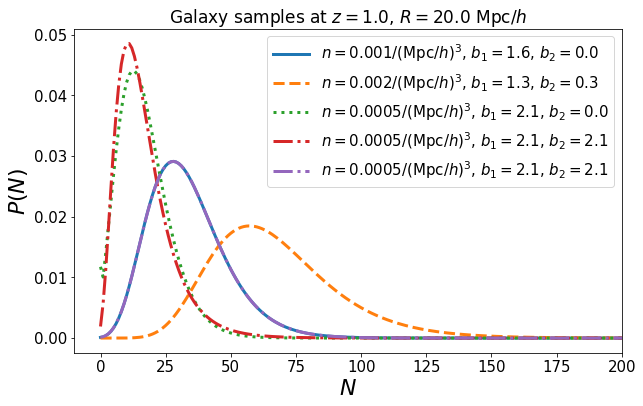

In [26]:
# plotting CiC PDF for each sample
plt.figure(figsize=(10,6))
plt.plot(range(0,N_max+1), P_of_N_values_sample_1, label="$n=$"+str(density_sample_1)+"/$($Mpc$/h)^3$, $b_1=$"+str(b1_sample_1)+", $b_2=$"+str(b2_sample_1), linestyle="solid", linewidth=3)
plt.plot(range(0,N_max+1), P_of_N_values_sample_2, label="$n=$"+str(density_sample_2)+"/$($Mpc$/h)^3$, $b_1=$"+str(b1_sample_2)+", $b_2=$"+str(b2_sample_2), linestyle="dashed", linewidth=3)
plt.plot(range(0,N_max+1), P_of_N_values_sample_3, label="$n=$"+str(density_sample_3)+"/$($Mpc$/h)^3$, $b_1=$"+str(b1_sample_3)+", $b_2=$"+str(b2_sample_3), linestyle="dotted", linewidth=3)
plt.plot(range(0,N_max+1), P_of_N_values_sample_4, label="$n=$"+str(density_sample_3)+"/$($Mpc$/h)^3$, $b_1=$"+str(b1_sample_3)+", $b_2=$"+str(b2_sample_4), linestyle="-.", linewidth=3)
plt.plot(range(0,N_max+1), P_of_N_values_sample_5, label="$n=$"+str(density_sample_3)+"/$($Mpc$/h)^3$, $b_1=$"+str(b1_sample_3)+", $b_2=$"+str(b2_sample_4), linestyle="-.", linewidth=3)
plt.xlim(-10,200)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$N$', size = 22)
plt.ylabel(r'$P(N)$', size = 22)
plt.legend(fontsize=15, handlelength=2.35)
plt.title('Galaxy samples at $z=$'+str(z)+', $R=$'+str(R)+' Mpc$/h$', size = 17)
plt.subplots_adjust(left=0.19, bottom=0.12, right=0.95, top=0.87)

# check normalisation of the CiC PDFs
print(np.sum(P_of_N_values_sample_1))
print(np.sum(P_of_N_values_sample_2))
print(np.sum(P_of_N_values_sample_3))
print(np.sum(P_of_N_values_sample_4))

In [27]:
# check normalisation of the CiC PDFs
print(np.sum(range(0,N_max+1)*P_of_N_values_sample_1))
print(np.sum(range(0,N_max+1)*P_of_N_values_sample_2))
print(np.sum(range(0,N_max+1)*P_of_N_values_sample_3))
print(np.sum(range(0,N_max+1)*P_of_N_values_sample_4))

33.510296282515924
67.02054252289348
16.762102961938204
16.755385982541057


In [28]:
print(np.sum(range(0,N_max+1)*P_of_N_values_sample_1)/(4.0*np.pi/3.0*20.0**3))
print(np.sum(range(0,N_max+1)*P_of_N_values_sample_2)/(4.0*np.pi/3.0*20.0**3))
print(np.sum(range(0,N_max+1)*P_of_N_values_sample_3)/(4.0*np.pi/3.0*20.0**3))
print(np.sum(range(0,N_max+1)*P_of_N_values_sample_4)/(4.0*np.pi/3.0*20.0**3))

0.00099999924334432
0.0019999969933535743
0.000500207164313956
0.0005000067192251368


0.999998970668072
0.9999989706680712


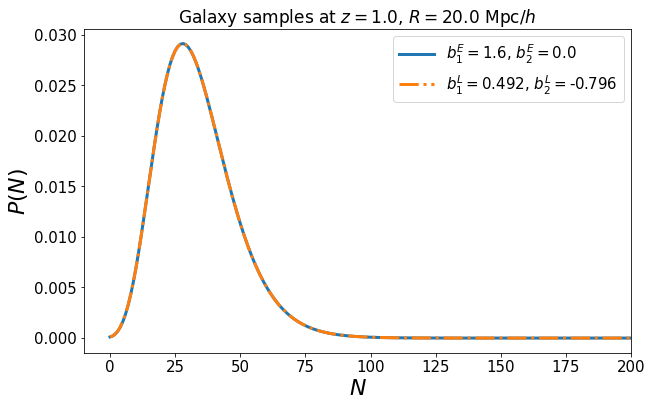

In [29]:
# plotting CiC PDF for each sample
plt.figure(figsize=(10,6))
plt.plot(range(0,N_max+1), P_of_N_values_sample_1, label="$b_1^E=$"+str(int(1000.0*b1_sample_1)/1000.0)+", $b_2^E=$"+str(int(1000.0*b2_sample_1)/1000.0), linestyle="solid", linewidth=3)
plt.plot(range(0,N_max+1), P_of_N_values_sample_5, label="$b_1^L=$"+str(int(1000.0*b1_sample_5)/1000.0)+", $b_2^L=$"+str(int(1000.0*b2_sample_5)/1000.0), linestyle="-.", linewidth=3)
plt.xlim(-10,200)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$N$', size = 22)
plt.ylabel(r'$P(N)$', size = 22)
plt.legend(fontsize=15, handlelength=2.35)
plt.title('Galaxy samples at $z=$'+str(z)+', $R=$'+str(R)+' Mpc$/h$', size = 17)
plt.subplots_adjust(left=0.19, bottom=0.12, right=0.95, top=0.87)

# check normalisation of the CiC PDFs
print(np.sum(P_of_N_values_sample_1))
print(np.sum(P_of_N_values_sample_5))

# Section 5: creating line-of-sight projected galaxy samples and computing their counts-in-cells PDF

## This part also uses the bias and shot-noise model described in section IV.C.2 of https://arxiv.org/abs/1710.05162 .

In [30]:



add_projected_galaxy_sample = lib.add_projected_galaxy_sample
# add_projected_galaxy_sample          (int index_of_universe, const char *n_of_z_file, double density_in_1_over_arcminSq,        double b1,        double b2,       double a0,       double a1,       double a2, int bias_model)
add_projected_galaxy_sample.argtypes = [         ctypes.c_int,         ctypes.c_char_p,                    ctypes.c_double,  ctypes.c_double,  ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double,   ctypes.c_int]
add_projected_galaxy_sample.restype = None


return_N_max_projected = lib.return_N_max_projected
# int return_N_max_projected      (int index_of_galaxy_sample, double R_in_Mpc_over_h, double var_NL_rescale)
return_N_max_projected.argtypes = [              ctypes.c_int,        ctypes.c_double,       ctypes.c_double]
return_N_max_projected.restype = ctypes.c_int


change_parameters_of_projected_galaxy_sample = lib.change_parameters_of_projected_galaxy_sample
# change_parameters_of_projected_galaxy_sample          (int index_of_galaxy_sample,        double z, double density_in_1_over_arcminSq,        double b1,        double b2,       double a0,       double a1, int bias_model)
change_parameters_of_projected_galaxy_sample.argtypes = [              ctypes.c_int, ctypes.c_double,                    ctypes.c_double,  ctypes.c_double,  ctypes.c_double, ctypes.c_double, ctypes.c_double,   ctypes.c_int]
change_parameters_of_projected_galaxy_sample.restype = None

change_b2_to_minimise_negative_densities_projected = lib.change_b2_to_minimise_negative_densities_projected
# change_b2_to_minimise_negative_densities_projected          (int index_of_galaxy_sample, double R_in_Mpc_over_h, double var_NL_rescale)
change_b2_to_minimise_negative_densities_projected.argtypes = [              ctypes.c_int,        ctypes.c_double,       ctypes.c_double]
change_b2_to_minimise_negative_densities_projected.restype = ctypes.c_double


In [31]:
# Creating projected galaxy sample
bias_model = 0
density_sample_1 = 46.200759199/(np.pi*20.0**2)
b1_sample_1 = 1.6
b2_sample_1 = 0.0
a0 = 1.26
a1 = 0.28

# switching to DSS best fit:
#density_sample_1 = 45.5878/(np.pi*20.0**2)
#b1_sample_1 = 1.75
#b2_sample_1 = 0.0
#a0 = 1.47
#a1 = 1.77

n_of_z_file_str = 'data/redshift_distributions/DESY1_redmagic.dat'
n_of_z_file = ctypes.c_char_p(n_of_z_file_str.encode('utf-8'))
add_projected_galaxy_sample(0, n_of_z_file, density_sample_1, b1_sample_1, b2_sample_1, a0, a1, 0.0, bias_model)

In [32]:
# Creating projected galaxy sample with Lagrangian bias parametrisation
bias_model = 1
density_sample_2 = 46.200759199/(np.pi*20.0**2)
b1_sample_2 = 1.6 - 1.0
b2_sample_2 = 0.0 - 8.0/21.0*b1_sample_2
a0 = 1.26
a1 = 0.28

n_of_z_file_str = 'data/redshift_distributions/DESY1_redmagic.dat'
n_of_z_file = ctypes.c_char_p(n_of_z_file_str.encode('utf-8'))
add_projected_galaxy_sample(0, n_of_z_file, density_sample_2, b1_sample_2, b2_sample_2, a0, a1, 0.0, bias_model)

In [33]:

theta = 20.0
N_max = np.min([return_N_max_projected(0, theta, 1.0), return_N_max_projected(1, theta, 1.0)])
print(N_max)

return_CiC_PDF_projected = lib.return_CiC_PDF_projected
#           return_CiC_PDF_projected(                       double* P_of_N, double R_in_Mpc_over_h,     double f_NL, double var_NL_rescale, int index_of_galaxy_sample)
return_CiC_PDF_projected.argtypes = [ctypes.POINTER(ctypes.c_double*(N_max+1)),        ctypes.c_double, ctypes.c_double,       ctypes.c_double,               ctypes.c_int]
return_CiC_PDF_projected.restype = None

return_CiC_PDF_projected_Gauss = lib.return_CiC_PDF_projected_Gauss
#           return_CiC_PDF_projected(                       double* P_of_N, double R_in_Mpc_over_h,     double f_NL, double var_NL_rescale, int index_of_galaxy_sample)
return_CiC_PDF_projected_Gauss.argtypes = [ctypes.POINTER(ctypes.c_double*(N_max+1)),        ctypes.c_double, ctypes.c_double,       ctypes.c_double,               ctypes.c_int]
return_CiC_PDF_projected_Gauss.restype = None

## This function returns the count-in-cells PDF of a 3D galaxy field
# - at redshift z
# - angular top-hat smoothing radius theta
# - with primordial bispectrum amplitute f_NL
# - non-linear variance being var_NL_rescale*halofit (Takahashi et al. 2012, Smith et al. 2003)
# - for galaxy sample index_of_galaxy_sample (= 0 if you have only created one galaxy sample)
def CiC_projected(theta, f_NL, var_NL_rescale, index_of_galaxy_sample):
    P_of_N_values        = (ctypes.c_double*(N_max+1))()
    return_CiC_PDF_projected(ctypes.byref(P_of_N_values), theta, f_NL, var_NL_rescale, index_of_galaxy_sample)
    return np.array(P_of_N_values)

## This function returns the count-in-cells PDF of a 3D galaxy field
# - at redshift z
# - angular top-hat smoothing radius theta
# - with primordial bispectrum amplitute f_NL
# - non-linear variance being var_NL_rescale*halofit (Takahashi et al. 2012, Smith et al. 2003)
# - for galaxy sample index_of_galaxy_sample (= 0 if you have only created one galaxy sample)
def CiC_projected_Gauss(theta, f_NL, var_NL_rescale, index_of_galaxy_sample):
    P_of_N_values        = (ctypes.c_double*(N_max+1))()
    return_CiC_PDF_projected_Gauss(ctypes.byref(P_of_N_values), theta, f_NL, var_NL_rescale, index_of_galaxy_sample)
    return np.array(P_of_N_values)

204


In [34]:
P_of_N_values_projected = CiC_projected(theta, 0.0, 1.0, 0)
P_of_N_values_projected_Gauss = CiC_projected_Gauss(theta, 0.0, 1.0, 0)
P_of_N_values_projected_Lagrange = CiC_projected(theta, 0.0, 1.0, 1)

0.9999980127979035
0.9999980127979035
46.200548479537396
46.200549314135436


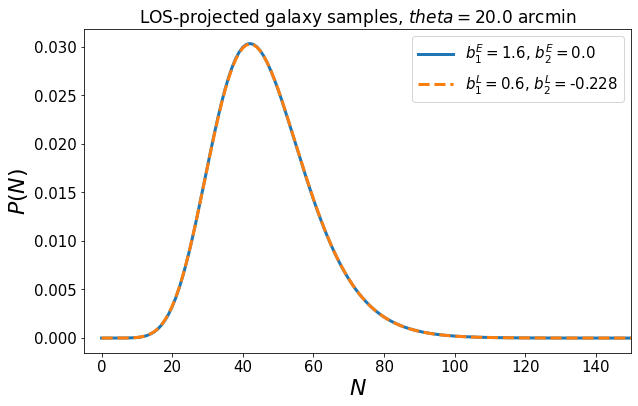

In [35]:
# plotting CiC PDF for each sample
plt.figure(figsize=(10,6))
plt.plot(range(0,N_max+1), P_of_N_values_projected, label="$b_1^E=$"+str(int(1000.0*b1_sample_1)/1000.0)+", $b_2^E=$"+str(int(1000.0*b2_sample_1)/1000.0), linestyle="solid", linewidth=3)
plt.plot(range(0,N_max+1), P_of_N_values_projected_Lagrange, label="$b_1^L=$"+str(int(1000.0*b1_sample_2)/1000.0)+", $b_2^L=$"+str(int(1000.0*b2_sample_2)/1000.0), linestyle="dashed", linewidth=3)
plt.xlim(-5,150)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$N$', size = 22)
plt.ylabel(r'$P(N)$', size = 22)
plt.legend(fontsize=15, handlelength=2.35)
plt.title('LOS-projected galaxy samples, $theta=$'+str(theta)+' arcmin', size = 17)
plt.subplots_adjust(left=0.19, bottom=0.12, right=0.95, top=0.87)

# check normalisation of the CiC PDFs
print(np.sum(P_of_N_values_projected))
print(np.sum(P_of_N_values_projected_Lagrange))
print(np.sum(P_of_N_values_projected*range(0,len(P_of_N_values_projected))))
print(np.sum(P_of_N_values_projected_Lagrange*range(0,len(P_of_N_values_projected_Lagrange))))

### Computing the skewness of the linear density field (this time in cylinders, as required for line-of-sight projected density fields)
### Defining $\epsilon_3(R) \equiv <\delta_R^3>/\sigma_R^2$ the function set_primordial_skewness_from_eps3_powerlaw_approximation assumed that $\epsilon_3(R) \approx A_{\epsilon_3}*(R/R_0)^{n_{\epsilon_3}}$ and computes $A_{\epsilon_3}$ and $n_{\epsilon_3}$ at $R = R_0$.
### Alternatively, see also set_primordial_skewness_2D in python_interfaces.cpp

In [36]:

return_R_in_Mpc_over_h_from_angular_scale = lib.return_R_in_Mpc_over_h_from_angular_scale
# return_R_in_Mpc_over_h_from_angular_scale          (int index_of_galaxy_sample, double theta_in_arcmin)
return_R_in_Mpc_over_h_from_angular_scale.argtypes = [              ctypes.c_int,        ctypes.c_double]
return_R_in_Mpc_over_h_from_angular_scale.restype = ctypes.c_double

R_2D = return_R_in_Mpc_over_h_from_angular_scale(0, theta)
print(R_2D)

set_primordial_skewness_from_eps3_powerlaw_approximation_2D = lib.set_primordial_skewness_from_eps3_powerlaw_approximation_2D
# set_primordial_skewness_from_eps3_powerlaw_approximation_2D          (int index_of_universe, int PNG_modus, double R_0_in_Mpc_over_h)
set_primordial_skewness_from_eps3_powerlaw_approximation_2D.argtypes = [           ctypes.c_int,  ctypes.c_int,          ctypes.c_double]
set_primordial_skewness_from_eps3_powerlaw_approximation_2D.restype = None

set_primordial_skewness_from_eps3_powerlaw_approximation_2D(0, 1, R_2D)

5.651836099473295


In [37]:
P_of_N_values_projected_PNG = CiC_projected(theta, -3.0, 1.0, 0)

In [38]:
print(np.sum(P_of_N_values_projected_PNG))
print(np.sum(P_of_N_values_projected_PNG*range(0,len(P_of_N_values_projected_PNG))))

0.9999973293943984
46.20049701430576


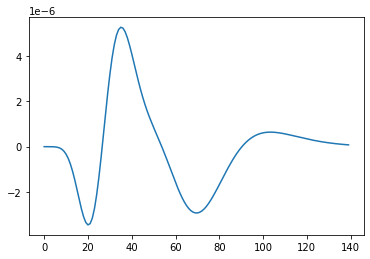

In [39]:
N_comparison = np.min([len(P_of_N_values_projected_PNG), len(P_of_N_values_projected), 140])
plt.plot(range(0, N_comparison), P_of_N_values_projected_PNG[:N_comparison]-P_of_N_values_projected[:N_comparison])

# Section 6: convergence PDFs

In [40]:
# N_delta has to be hardcoded, because is it needed for defining the python-c++ interface
return_Ndelta = lib.return_Ndelta
return_Ndelta.argtypes = []
return_Ndelta.restype = ctypes.c_int
N_delta = return_Ndelta()

return_convergence_PDF_from_single_z = lib.return_convergence_PDF_from_single_z
# return_convergence_PDF_from_single_z          (                   double* kappa_values,                                      double* PDF,        double z, double theta_in_arcmin,     double f_NL, double var_NL_rescale, int index_of_universe)
return_convergence_PDF_from_single_z.argtypes = [ctypes.POINTER(ctypes.c_double*N_delta),          ctypes.POINTER(ctypes.c_double*N_delta), ctypes.c_double,        ctypes.c_double, ctypes.c_double,       ctypes.c_double,          ctypes.c_int]
return_convergence_PDF_from_single_z.restype = None

return_convergence_PDF_from_source_sample = lib.return_convergence_PDF_from_source_sample
# return_convergence_PDF_from_source_sample          (                   double* kappa_values,                                      double* PDF, double theta_in_arcmin,     double f_NL, double var_NL_rescale, int index_of_galaxy_sample)
return_convergence_PDF_from_source_sample.argtypes = [ctypes.POINTER(ctypes.c_double*N_delta),          ctypes.POINTER(ctypes.c_double*N_delta),        ctypes.c_double, ctypes.c_double,       ctypes.c_double,               ctypes.c_int]
return_convergence_PDF_from_source_sample.restype = None

## This function returns the probability distribution function (PDF) of the cosmic shear convergence
# - from sources at redshift z
# - top-hat smoothing radius theta [arcmin]
# - with primordial bispectrum amplitute f_NL
# - non-linear variance being var_NL_rescale*halofit (Takahashi et al. 2012, Smith et al. 2003)
# - for universe index_of_universe (= 0 if you have only created one universe
def convergence_PDF_at_single_z(z, theta, f_NL, var_NL_rescale, index_of_universe):
    kappa_values     = (ctypes.c_double*N_delta)()
    PDF_values       = (ctypes.c_double*N_delta)()
    return_convergence_PDF_from_single_z(ctypes.byref(kappa_values), ctypes.byref(PDF_values), z, theta, f_NL, var_NL_rescale, index_of_universe)
    return np.array(kappa_values), np.array(PDF_values)


## This function returns the probability distribution function (PDF) of the cosmic shear convergence
# - for galaxy sample index_of_galaxy_sample (= 0 if you have only created one galaxy sample)
# - top-hat smoothing radius theta [arcmin]
# - with primordial bispectrum amplitute f_NL
# - non-linear variance being var_NL_rescale*halofit (Takahashi et al. 2012, Smith et al. 2003)
def convergence_PDF_from_source_sample(theta, f_NL, var_NL_rescale, index_of_galaxy_sample):
    kappa_values     = (ctypes.c_double*N_delta)()
    PDF_values       = (ctypes.c_double*N_delta)()
    return_convergence_PDF_from_source_sample(ctypes.byref(kappa_values), ctypes.byref(PDF_values), theta, f_NL, var_NL_rescale, index_of_galaxy_sample)
    return np.array(kappa_values), np.array(PDF_values)


In [42]:
# Creating a source galaxy sample
density_sample_1 = 46.200759199/(np.pi*20.0**2)
b1_sample_1 = 1.6 # in principle irrelevant for convergence maps
b2_sample_1 = 0.0 # in principle irrelevant for convergence maps
a0 = 1.26 # in principle irrelevant for convergence maps
a1 = 0.28 # in principle irrelevant for convergence maps
n_of_z_file_str = 'data/redshift_distributions/source_galaxy_pofz.tab'
n_of_z_file = ctypes.c_char_p(n_of_z_file_str.encode('utf-8'))
add_projected_galaxy_sample(0, n_of_z_file, density_sample_1, b1_sample_1, b2_sample_1, a0, a1, 0.0, 0)

In [43]:
z = 1.0
theta = 20.0
f_NL = 0.0 # if you want f_NL != 0 , you need to compute initial Bispectrum first
           # (see e.g. set_primordial_skewness_from_eps3_powerlaw_approximation_2D above)
var_NL_rescale = 1.0
index_of_universe = 0
kappa_values_single_z, PDF_values_single_z = convergence_PDF_at_single_z(z, theta, f_NL, var_NL_rescale, index_of_universe)
index_of_galaxy_sample = 2
kappa_values_from_sample_0, PDF_values_from_sample_0 = convergence_PDF_from_source_sample(theta, f_NL, var_NL_rescale, index_of_galaxy_sample)

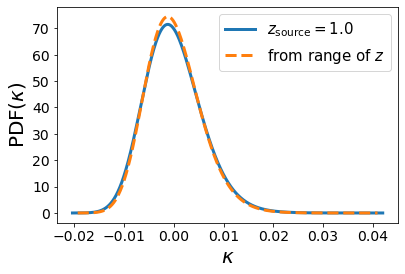

In [44]:
plt.plot(kappa_values_single_z, PDF_values_single_z, linewidth=3, linestyle='solid', label=r'$z_{\mathrm{source}}=$'+str(z))
plt.plot(kappa_values_from_sample_0, PDF_values_from_sample_0, linewidth=3, linestyle='dashed', label=r'from range of $z$')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel(r'$\kappa$', size = 20)
plt.ylabel(r'$\mathrm{PDF}(\kappa)$', size = 20)
plt.legend(fontsize=15)
plt.subplots_adjust(left  = 0.18, right = 0.97, bottom=0.17, top=0.92)

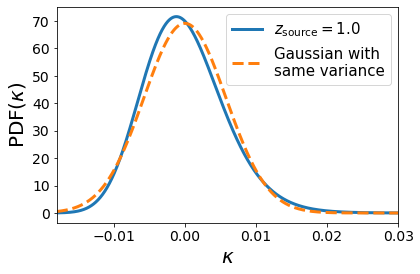

In [45]:
variance = np.sum(kappa_values_single_z**2*PDF_values_single_z)/np.sum(PDF_values_single_z)
def Gauss_PDF(kappa):
    return 1.0/np.sqrt(2.0*np.pi*variance)*np.exp(-0.5*kappa**2/variance)

plt.plot(kappa_values_single_z, PDF_values_single_z, linewidth=3, linestyle='solid', label=r'$z_{\mathrm{source}}=$'+str(z))
plt.plot(kappa_values_single_z, Gauss_PDF(kappa_values_single_z), linewidth=3, linestyle='dashed', label='Gaussian with\nsame variance')


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel(r'$\kappa$', size = 20)
plt.ylabel(r'$\mathrm{PDF}(\kappa)$', size = 20)
plt.xlim(-0.018, 0.03)
plt.legend(fontsize=15)
plt.subplots_adjust(left  = 0.18, right = 0.97, bottom=0.17, top=0.92)

In [46]:
print(variance)

3.3415539640841254e-05


In [47]:
variance = np.sum(kappa_values_from_sample_0**2*PDF_values_from_sample_0)/np.sum(PDF_values_from_sample_0)
print(variance/3.0842747049084154e-05)

0.9999996225356279
